In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
sns.set_style("white")

from pmagpy import ipmag, pmag

from vgptools.utils import (spherical2cartesian,GCD_cartesian) 
from vgptools.utils_APWPs import (running_mean_APWP_shape, get_pseudo_vgps, MC_error_prop_ensemble_results)
from vgptools.utils_visualization import  plot_pole, plot_pole_A95
from vgptools.utils_classes import PC, quantiles
np.random.seed(1)

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
df_filtered_directions = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')
df_pole_compilation  = pd.read_csv(current_path +'/data/df_pole_compilation_by_study.csv')

# list to store the models
models = []

## 1. Moving average classic approach on poles

Set the classical parameters

In [4]:
min_age = 0
max_age = 65
window_length = 20
time_step = 10

Run the Moving average on paleopoles 

(Note: There may be multiple poles for each file, as multiple studies have been conducted in the same area. This is basically the content of each datasheet)

In [5]:
RM_1_classic = running_mean_APWP_shape(df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic['method'] = "RM_classic"
models.append(RM_1_classic)
RM_1_classic.head(10)

,age,N,n_studies,k,A95,csd,plon,plat,foliation,lineation,collinearity,coplanarity,elong_dir,GCD,APW_rate,angle,method
0,0.0,17.0,15.0,155.075584,2.873466,6.504491,0.000000,-90.000000,0.673561,4.819217,7.154834,5.492778,52.950148,NaN,NaN,NaN,RM_classic
1,10.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,0.699943,4.806285,6.866678,5.506228,48.438290,0.375266,0.037527,163.155600,RM_classic
2,20.0,7.0,6.0,576.253052,2.516820,3.374259,-11.644529,-81.643535,2.379876,5.904994,2.481219,8.284869,28.613948,6.633272,0.663327,35.000034,RM_classic
3,30.0,10.0,7.0,352.037229,2.578271,4.317086,-27.417630,-82.908968,3.219457,5.313450,1.650418,8.532907,28.978465,2.457136,0.245714,174.787778,RM_classic
4,40.0,13.0,8.0,106.788061,4.029946,7.838332,-42.018275,-83.233935,1.211546,4.320118,3.565790,5.531664,-94.770122,1.785938,0.178594,29.497476,RM_classic
5,50.0,12.0,9.0,83.449008,4.779163,8.866953,-27.811855,-81.677918,0.806618,4.186000,5.189566,4.992618,-92.200769,2.417822,0.241782,178.060425,RM_classic
6,60.0,4.0,4.0,222.541387,6.172545,5.429747,-13.837826,-78.640250,1.695166,5.163581,3.046062,6.858747,-34.503896,3.843211,0.384321,NaN,RM_classic


### 2. Running means ensemble from $pseudo$-VGPs approach (Vaes et al. 2022)

In [6]:
min_age = 0
max_age = 65
window_length = 20
time_step = 1

In [7]:
%%time
np.random.seed(10) # seed for reproducibility
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation) # function to generate pseudo-VGPs from pole's pdfs
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP_shape(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i
    RM_APWP_parametric_temp['plon'] = RM_APWP_parametric_temp['plon'].apply(lambda plon: plon - 360 if plon > 180 else plon)    
    RM_APWP_parametric_temp['method'] = "RM_pseudoVGPs_ensemble"   
       
    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)

models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 1min 28s, sys: 227 ms, total: 1min 28s
Wall time: 1min 28s


### 3. Monte-Carlo uncertainty propagation scheme proposed in this study. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [8]:
min_age = 0
max_age = 65
window_length = 21
time_step = 1

In [9]:
%%time
np.random.seed(10) # seed for reproducibility
df_RM_ensemble = MC_error_prop_ensemble_results(df_filtered_directions, n_sims = 100,
                                                 study_label= 'Study', slat_label='slat', slon_label='slon',
                                                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                                                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                                                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                                                 window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)


CPU times: user 14min 53s, sys: 2.73 s, total: 14min 56s
Wall time: 14min 57s


### Calcultes the Princ. Components of the ensemble
We first select confidence interval at which we will work

In [10]:
quantile = 95

In [11]:
# Since the Latitude and Longitude covaries, we need to calculate the Principal component for each timre-dependant point Cloud 
ensemble_PC_Vaes = PC(RM_2_ensemble_pseudoVGP,"age","plat","plon") # set principal component for each Age
ensemble_PC_Gallo = PC(df_RM_ensemble,"age","plat","plon") # set principal component for each Age

# Comparison plot

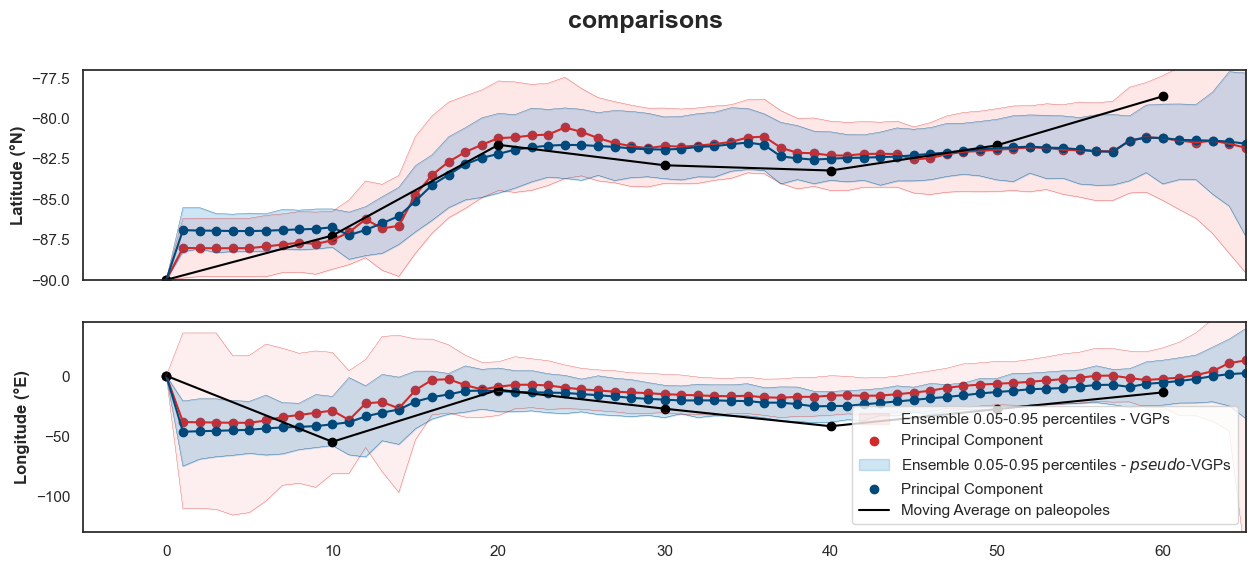

In [17]:
title = "comparisons"

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
# axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
# axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')

axes[0].set_ylim(-90,-77)
axes[1].set_ylim(-130,45)
axes[0].set_xlim(-5,65)
axes[1].set_xlim(-5,65)

# LATITUDE
# Gallo
axes[0].fill_between(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[2], ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[3], color= "#f98787", alpha=.20)
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[3],color="#d12a2a",linewidth=0.2)
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[2],color="#d12a2a",linewidth=0.2)
axes[0].scatter(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[1],color="#d12a2a")
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[1],color="#d12a2a")
# Vaes
axes[0].fill_between(ensemble_PC_Vaes.X,ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[2],ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[3], color= "#0E7DC9", alpha=.20)
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[3],color="#00497A",linewidth=0.2)
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[2],color="#00497A",linewidth=0.2)
axes[0].scatter(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[1],color="#00497A")
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[1],color="#00497A")
#CLASSIC
axes[0].plot(RM_1_classic.age, RM_1_classic.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic.age, RM_1_classic.plat, color="black") #CLASSIC

# LONGITUDE
# Gallo
axes[1].fill_between(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[0], ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[1], color= "#f9afaf", alpha=.20,label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles - VGPs")
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[1],color="#d12a2a",linewidth=0.2)
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[0],color="#d12a2a",linewidth=0.2)
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[0], '-',color="#d12a2a")
axes[1].scatter(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[0],color="#d12a2a",label="Principal Component")
# Vaes
axes[1].fill_between(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[0], ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[1], color= "#0E7DC9", alpha=.20,label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles - $pseudo$-VGPs")
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[1],color="#00497A",linewidth=0.2)
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[0],color="#00497A",linewidth=0.2)
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[0], '-',color="#00497A")
axes[1].scatter(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[0],color="#00497A",label="Principal Component")
# Classic
axes[1].plot(RM_1_classic.age, RM_1_classic.plon, '-',color="black", label = "Moving Average on paleopoles") #CLASSIC
axes[1].scatter(RM_1_classic.age, RM_1_classic.plon, color="black") #CLASSIC

plt.legend(loc="lower right")
# plt.savefig(current_path + '/figures/4/lat_lon_comparison.svg', dpi =600, bbox_inches='tight')

# Misfit of the Classical approach vs. the psuedoVGP and our current approach

Here, we compare the results of the classic approach (running means on paleopoles) with the approach proposed in the current contribution and the Moving averages on $pseudo$-VGPs drawn from the Paleopoles _pdf_ s

In [13]:
for i, row in RM_1_classic.iterrows():
    
    mean_cartesian = spherical2cartesian([np.radians(row.plat),np.radians(row.plon)])
    
    ind = np.where(ensemble_PC_Gallo.X == row.age)    
    vgps_cart = spherical2cartesian([np.radians(ensemble_PC_Gallo.PC(quantile)[1][ind]), np.radians(ensemble_PC_Gallo.PC(quantile)[0][ind])])
    pseudo_cart = spherical2cartesian([np.radians(ensemble_PC_Vaes.PC(quantile)[1][ind]), np.radians(ensemble_PC_Vaes.PC(quantile)[0][ind])])  
    
    RM_1_classic.loc[i, 'Distance_to_pseudo']=np.degrees(GCD_cartesian(mean_cartesian,pseudo_cart))
    RM_1_classic.loc[i, 'Distance_to_VPGs']=np.degrees(GCD_cartesian(mean_cartesian,vgps_cart))

In [14]:
RM_1_classic_melt = RM_1_classic[['age','Distance_to_pseudo','Distance_to_VPGs']].melt('age', var_name='method', value_name='Angle')

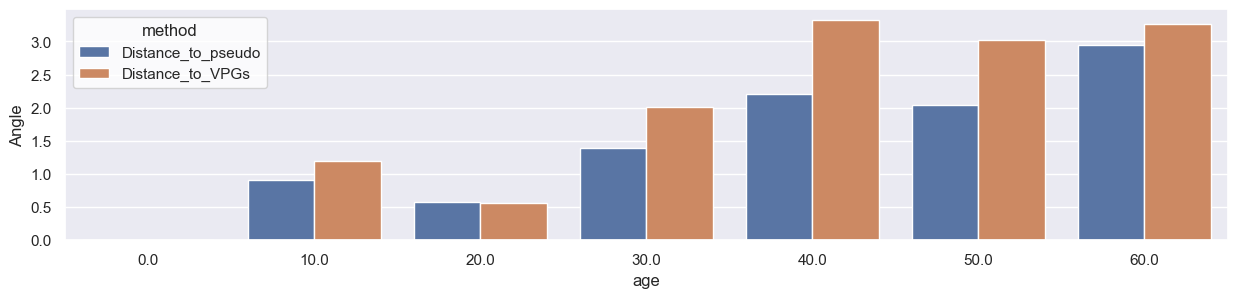

In [18]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,3))
ax.set_xlim(0,65)
sns.set_style("white")
sns.barplot(x="age", y="Angle", hue = 'method', data=RM_1_classic_melt,ax=ax)
plt.savefig(current_path + '/figures/4/4c_gcds.svg', dpi =600, bbox_inches='tight')

## APWP from this study (Figure 4a)

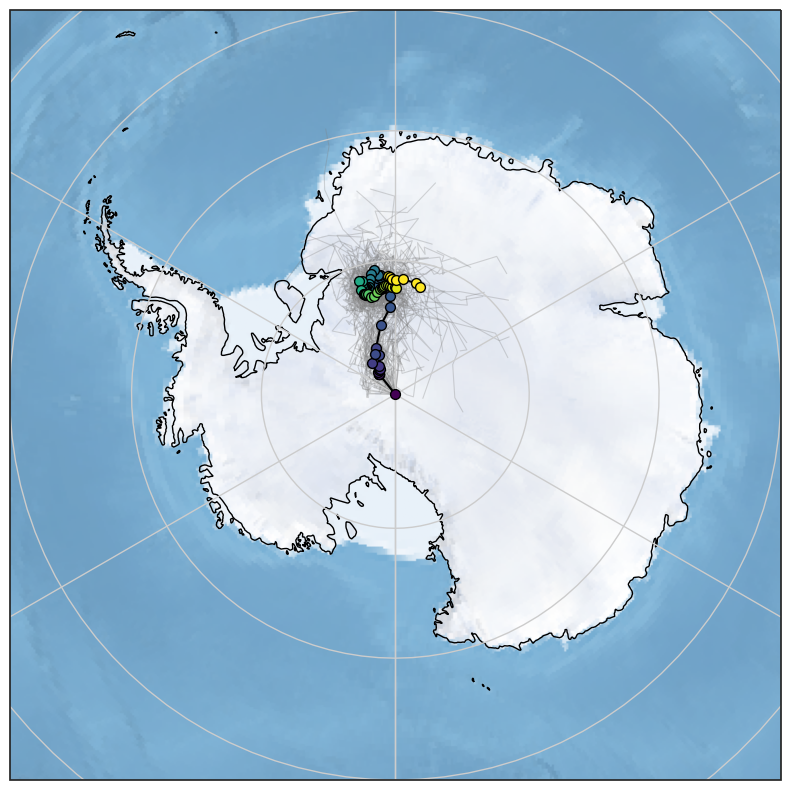

In [19]:
# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC_Gallo.PC(quantile)[0].tolist(), ensemble_PC_Gallo.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)

# Color coded Paleopoles and 95 circles.
# for i in zip(ensemble_PC.PC()[1].tolist(), ensemble_PC.PC()[0].tolist(),ensemble_PC.PC()[2].tolist(), df_RM_ensemble['age'].unique().transpose()):
#     plot_pole_A95(i[0],i[1],i[2],i[3],0,60,ax)
    
for i in zip(ensemble_PC_Gallo.PC(quantile)[1].tolist(), ensemble_PC_Gallo.PC(quantile)[0].tolist(),ensemble_PC_Gallo.X.tolist(), df_RM_ensemble['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,60,ax)
    
# Runs in grey (just plotting 50 runs)
for run, df_run in df_RM_ensemble[df_RM_ensemble['run']<50].groupby('run'):
    plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)
plt.savefig(current_path + '/figures/4/MovAverga_thisStudy.svg', dpi =600, bbox_inches='tight')  
plt.show()

## Vaes et al. (2022) Approach - Running mean on $pseudo$-VGPs

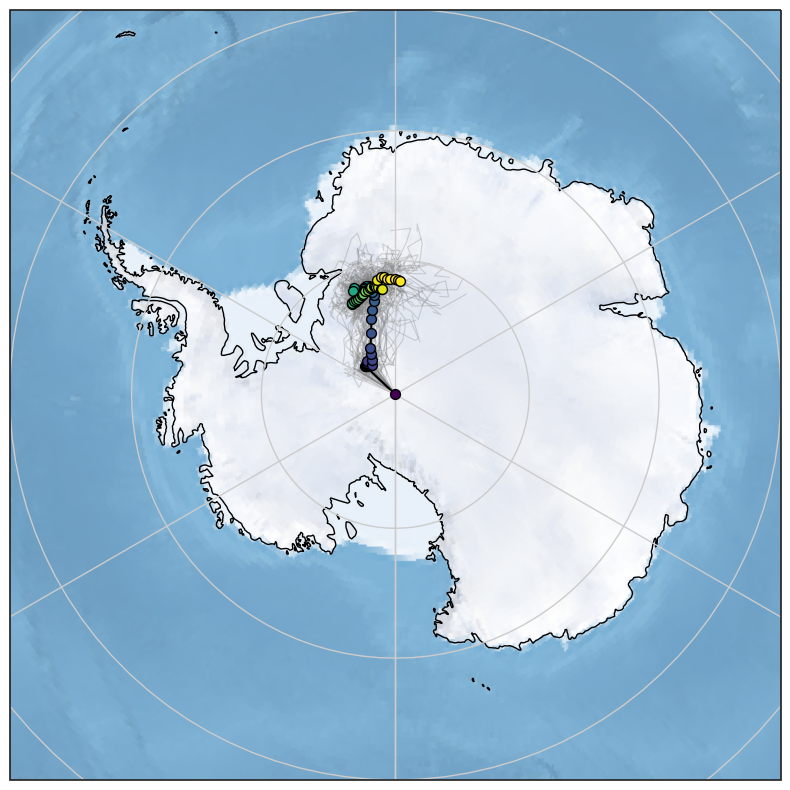

In [20]:
# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC_Vaes.PC(quantile)[0].tolist(), ensemble_PC_Vaes.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)

# Color coded Paleopoles and 95 circles.
# for i in zip(ensemble_PC.PC()[1].tolist(), ensemble_PC.PC()[0].tolist(),ensemble_PC.PC()[2].tolist(), df_RM_ensemble['age'].unique().transpose()):
#     plot_pole_A95(i[0],i[1],i[2],i[3],0,60,ax)
    
for i in zip(ensemble_PC_Vaes.PC(quantile)[1].tolist(), ensemble_PC_Vaes.PC(quantile)[0].tolist(),ensemble_PC_Vaes.X.tolist(), RM_2_ensemble_pseudoVGP['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,60,ax)
    
# Runs in grey (just plotting 50 runs)
for run, df_run in RM_2_ensemble_pseudoVGP[RM_2_ensemble_pseudoVGP['run']<50].groupby('run'):
    plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)
plt.savefig(current_path + '/figures/4/MovAverages_VaesApproach.svg', dpi =600, bbox_inches='tight')  
plt.show()

## Classic Moving Averages (Time-step = 10 Ma, Window width = 20 Ma)

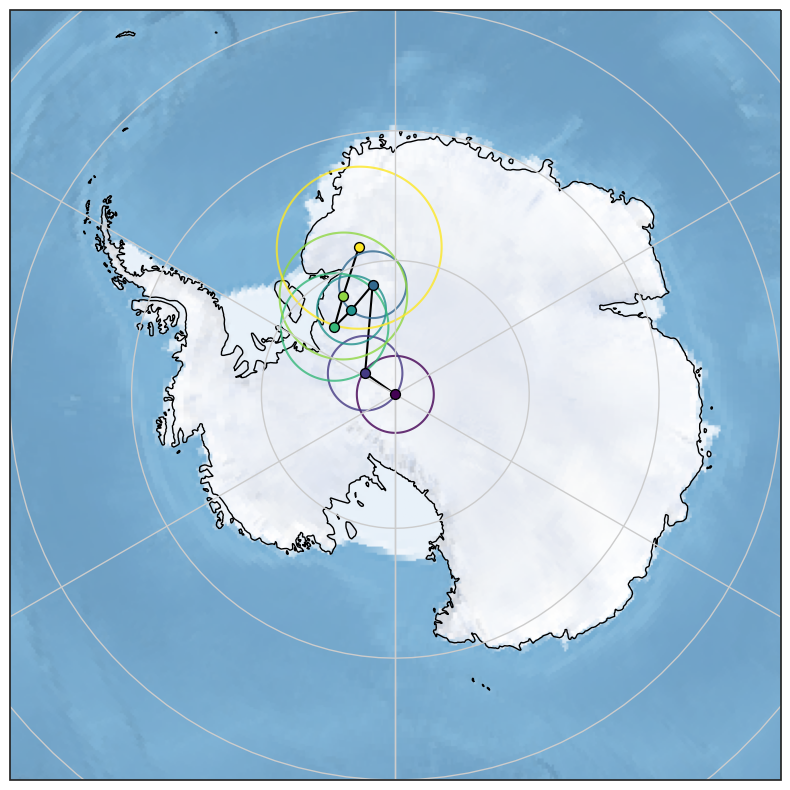

In [21]:
# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# A black path to connect the poles.
plt.plot(RM_1_classic['plon'],RM_1_classic['plat'],transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)

#Color coded Paleopoles and 95 circles.
for i in zip(RM_1_classic['plat'].tolist(),RM_1_classic['plon'].tolist(), RM_1_classic['A95'].tolist(), RM_1_classic['age'].unique().transpose()):
    plot_pole_A95(i[0],i[1],i[2],i[3],0,60,ax)
plt.savefig(current_path + '/figures/4/MovAverage_CLASSIC.svg', dpi =600, bbox_inches='tight')    
plt.show()

In [87]:
RM_1_classic

,age,N,n_studies,k,A95,csd,plon,plat,foliation,lineation,collinearity,coplanarity,elong_dir,GCD,APW_rate,angle,method,Distance_to_pseudo,Distance_to_VPGs
0,0.0,17.0,15.0,155.075584,2.873466,6.504491,0.000000,-90.000000,0.673561,4.819217,7.154834,5.492778,52.950148,NaN,NaN,NaN,RM_classic,0.000000,0.000000
1,10.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,0.699943,4.806285,6.866678,5.506228,48.438290,0.375266,0.037527,163.155600,RM_classic,0.913958,1.155114
2,20.0,7.0,6.0,576.253052,2.516820,3.374259,-11.644529,-81.643535,2.379876,5.904994,2.481219,8.284869,28.613948,6.633272,0.663327,35.000034,RM_classic,0.580347,0.601245
3,30.0,10.0,7.0,352.037229,2.578271,4.317086,-27.417630,-82.908968,3.219457,5.313450,1.650418,8.532907,28.978465,2.457136,0.245714,174.787778,RM_classic,1.379603,2.012610
4,40.0,13.0,8.0,106.788061,4.029946,7.838332,-42.018275,-83.233935,1.211546,4.320118,3.565790,5.531664,-94.770122,1.785938,0.178594,29.497476,RM_classic,2.203698,3.306227
5,50.0,12.0,9.0,83.449008,4.779163,8.866953,-27.811855,-81.677918,0.806618,4.186000,5.189566,4.992618,-92.200769,2.417822,0.241782,178.060425,RM_classic,2.017987,3.036005
6,60.0,4.0,4.0,222.541387,6.172545,5.429747,-13.837826,-78.640250,1.695166,5.163581,3.046062,6.858747,-34.503896,3.843211,0.384321,NaN,RM_classic,2.940337,3.272886
